# Util-kit

In [1]:
import io
import pandas as pd
import numpy as np
import itertools
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt     
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
!pip install pandas numpy
!pip install -U scikit-learn
!pip install -U matplotlib

In [3]:
attacks = [
    {"start":"2019-07-20 15:08:46.004013+08:00", "end":"2019-07-20 15:10:31.004013+08:00", "cols": ["FIT 401", "UV401"]},
    {"start":"2019-07-20 15:15:00.004013+08:00", "end":"2019-07-20 15:19:32.004013+08:00", "cols": ["LIT 301"]},
    {"start":"2019-07-20 15:26:57.004013+08:00", "end":"2019-07-20 15:30:48.004013+08:00", "cols": ["P601 Status"]},
    {"start":"2019-07-20 15:38:50.004013+08:00", "end":"2019-07-20 15:46:20.004013+08:00", "cols": ["MV201", "P101 Status"]},
    {"start":"2019-07-20 15:54:00.004013+08:00", "end":"2019-07-20 15:56:00.004013+08:00", "cols": ["MV 501"]},
    {"start":"2019-07-20 16:02:56.004013+08:00", "end":"2019-07-20 16:16:18.004013+08:00", "cols": ["P301 Status"]},
]

In [4]:
global raw_df
raw_df = None
def read_data():
    global raw_df
    if raw_df is None:
      raw_df = pd.read_excel('SWaT_dataset_Jul 19 v2.xlsx', parse_dates = ['GMT +0'], index_col = 'GMT +0')
      raw_df = raw_df.rename(columns=lambda x: x.strip())
      raw_df.index = raw_df.index.tz_convert('Asia/Singapore') + pd.Timedelta(minutes=2)
    return raw_df.copy()

In [5]:
def keep_columns(all, to_keep=["FIT 401", "LIT 301"]):
    if len(to_keep):
      return list(set(all).intersection(set(to_keep)))
    return all

In [6]:
def split_feature(df):
    cat_features = []
    numeric_features = []
    for col in df.columns:
        if len(df[col].unique()) < 4:
          cat_features.append(col)
        else: numeric_features.append(col)
    return cat_features, numeric_features

In [7]:
def preprocess_cat(df): 
    df = df.copy() 
    df['LS 201'] = np.where(df['LS 201'] == 'Active', 1, 0)
    df['LS 202'] = np.where(df['LS 202'] == 'Active', 1, 0)
    df['LSL 203'] = np.where(df['LSL 203'] == 'Inactive', 0, 1)
    df['LSLL 203'] = np.where(df['LSLL 203'] == 'Active', 1, 0)
    df['LS 401'] = np.where(df['LS 401'] == 'Active', 1, 0)
    df['LSH 601'] = np.where(df['LSH 601'] == 'Active', 1, 0)
    df['LSH 602'] = np.where(df['LSH 602'] == 'Active', 1, 0)
    df['LSH 603'] = np.where(df['LSH 603'] == 'Active', 1, 0)
    df['LSL 601'] = np.where(df['LSL 601'] == 'Active', 1, 0)
    df['LSL 602'] = np.where(df['LSL 602'] == 'Active', 1, 0)
    df['LSL 603'] = np.where(df['LSL 603'] == 'Active', 1, 0)
    return df

In [8]:
def preprocess(df, cols, to_plot=False):
    
    enc_df = None
    minmax_scale = None
    cat_features, numeric_features = split_feature(df)
    cat_features = keep_columns(cat_features, cols)
    numeric_features = keep_columns(numeric_features, cols)
    cols = numeric_features + cat_features

    df = df.copy()
    df = df[cols]
    #OneHotEncode categorical data
    if len(cat_features) > 0:
      encoder = OneHotEncoder(sparse = False)
      enc_df = pd.DataFrame(encoder.fit_transform(df[cat_features]))
      enc_df.index = df.index
    
    if len(numeric_features) > 0:
        # Normalize numerical data
        minmax_scale = pd.DataFrame(MinMaxScaler().fit_transform(df[numeric_features]))
        minmax_scale.index = df.index 
    
    if isinstance(enc_df, pd.DataFrame) and  isinstance(minmax_scale, pd.DataFrame):
        set_val = pd.concat([enc_df, minmax_scale], axis=1, ignore_index=True) 
        set_val = set_val.reindex(df.index)
    elif isinstance(enc_df, pd.DataFrame):
         set_val = enc_df
    elif isinstance(minmax_scale, pd.DataFrame):
         set_val = minmax_scale
    else:
         set_val = -1

    return set_val

In [9]:
def get_clean_df(cols=[], to_plot=False):
    df = read_data()
    df = preprocess_cat(df)
    sel = VarianceThreshold(threshold=0)
    sel.fit(df)  # fit finds the features with zero variance
    df = df[df.columns[sel.get_support()]]
    # print("Number of columns " + df.columns)
    df = preprocess(df, cols)
    return df

In [10]:
def list_to_str(cols):
    return "_".join(cols).replace(" ", "_")

In [11]:
def evaluate(df, start, end, ev_col):
    x = df[((df.index<=start)&(df.index<=end))]
    return len(x[x[ev_col]==-1])/len(x), len(df[df[ev_col]==-1])

In [12]:
def evaluate_all_features(df, attacks, ev_col):
    result = []
    ratio = 0
    for attack in attacks:
      x = df[((df.index<=attack["start"])&(df.index<=attack["end"]))]
      ratio += len(x[x[ev_col]==-1])/len(x)
    return ratio/len(attacks)

In [13]:
def plot_ts(x, y, colors, title):
    fig = plt.figure()
    fig.set_figwidth(25)
    ax1 = fig.add_subplot(111)
    ax1.set_title(title)
    sc = ax1.scatter(x,y, s=10,c=colors)
    plt.colorbar(sc)
    for attack in attacks:
      ax1.fill_between(x, 0, 1,where=(x >= attack["start"] )& (x<=attack["end"]),
                     color='red', alpha=0.5, transform=ax1.get_xaxis_transform())
    plt.show()

In [14]:
def unsupervised_iso_grid_search(df, max_samples, contaminations, n_estimators, max_features, attack):
    hypyer_parameters = [max_samples, contaminations, n_estimators, max_features]
    modified_df = df.copy()
    df_orginal = df.copy()
    best_model = {"model_name": None, "anomaly_percentage":0, "anomlaies_num":0}
    for a, b, c, d in itertools.product(*hypyer_parameters):
        model_name = f"iso_{a}_{b}_{c}_{d}"
        model = IsolationForest(max_samples=a, contamination=b, n_estimators=c, max_features=d)
        model.fit(df_orginal)
        modified_df[model_name] = model.predict(df_orginal)
        anomaly_percentage, anomlaies_num = evaluate(modified_df, attack["start"], attack["end"], model_name)
        if best_model["anomaly_percentage"] <  anomaly_percentage:
           best_model["anomaly_percentage"] = anomaly_percentage
           best_model["model_name"] = model_name
           best_model["anomlaies_num"] = anomlaies_num
        # print(f"{model_name}: {anomaly_percentage} - {best_model['anomlaies_num']}")  
    return best_model      

In [15]:
def fit_predict(all_features=False):
  if all_features is False:
      for x in attacks:
          df = get_clean_df(x["cols"])
          features = list_to_str(x["cols"])
          best_model = unsupervised_iso_grid_search(df, max_samples=[100, 200, 500, 'auto'],
                                    n_estimators=[50, 100, 200],
                                    contaminations=[0.1, 0.2, 0.3, 0.5,'auto'],
                                    max_features=[1],
                                    attack=x) # attack info used for evaluation
          print(f"Best model on {features} is {best_model['model_name']} with ratio {best_model['anomaly_percentage']} and {best_model['anomlaies_num']} total anomalies")
  else:
      df = get_clean_df(['FIT 401',
            'UV401',
            'LIT 301',
            'P601 Status',
            'MV201',
            'P101 Status',
            'MV 501',
            'P301 Status'])
      best_model = unsupervised_iso_grid_search_all_features(df, max_samples=['auto'],
                                    n_estimators=[50],
                                    max_features=[1],
                                    contaminations=['auto']) # attack info used for evaluation
      print(best_model)

In [43]:
def fit_predict_single(df_orginal, max_samples=100, contaminations='auto', n_estimators=50, max_features=1, features=[]):
    df = df_orginal.copy()
    model_name = f"iso_{max_samples}_{contaminations}_{n_estimators}_{max_features}"
    model = IsolationForest(max_samples=max_samples, contamination=contaminations, n_estimators=n_estimators, max_features=max_features)
    model.fit(df_orginal)
    df[model_name] = model.predict(df_orginal)
    res = evaluate_all_features(df, attacks, model_name)
    return res, model, model_name

In [44]:
def unsupervised_iso_grid_search_all_features(df_orginal, max_samples=[100, 200, 500, 'auto'],
                                    n_estimators=[50, 100, 200],
                                    contaminations=[0.1, 0.2, 0.3, 0.5,'auto'],
                                    max_features=[1],attacks=attacks):
    hypyer_parameters = [max_samples, contaminations, n_estimators, max_features]
    df = df_orginal.copy()
    best_model = {"model":None, "name":None, "res":0}
    for a, b, c, d in itertools.product(*hypyer_parameters):
        print(a,b,c,d)
        res, model, model_name = fit_predict_single(df, max_samples=a, contaminations=b, n_estimators=50, max_features=1, features=features)
        print(f"{model_name}: {res}")
        if res > best_model["res"]:
            best_model["res"] = res
            best_model["name"] = model_name
            best_model["model"] = model
    print(f"best model is {best_model['name']}: {best_model['res']}")
    return best_model

In [45]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
features = ['FIT 401',
            'UV401',
            'LIT 301',
            'P601 Status',
            'MV201',
            'P101 Status',
            'MV 501',
            'P301 Status']
df = get_clean_df(features)
best_model = unsupervised_iso_grid_search_all_features(df)

100 0.1 50 1
iso_100_0.1_50_1: 0.08932777061213097
100 0.1 100 1
iso_100_0.1_50_1: 0.08146766308956972
100 0.1 200 1
iso_100_0.1_50_1: 0.06959419333292315
100 0.2 50 1
iso_100_0.2_50_1: 0.1577816617537617
100 0.2 100 1
iso_100_0.2_50_1: 0.18073012493173493
100 0.2 200 1
iso_100_0.2_50_1: 0.1589547959227657
100 0.3 50 1
iso_100_0.3_50_1: 0.22654414824507696
100 0.3 100 1
iso_100_0.3_50_1: 0.26232727929592
100 0.3 200 1
iso_100_0.3_50_1: 0.224296877740889
100 0.5 50 1
iso_100_0.5_50_1: 0.5164235543055752
100 0.5 100 1
iso_100_0.5_50_1: 0.4644580256105743
100 0.5 200 1
iso_100_0.5_50_1: 0.4368041674392286
100 auto 50 1
iso_100_auto_50_1: 0.2922628526068782
100 auto 100 1
iso_100_auto_50_1: 0.07685112210469776
100 auto 200 1
iso_100_auto_50_1: 0.12013421266612771
200 0.1 50 1
iso_200_0.1_50_1: 0.06445557634926745
200 0.1 100 1
iso_200_0.1_50_1: 0.059636936111172656
200 0.1 200 1
iso_200_0.1_50_1: 0.07451372818362166
200 0.2 50 1
iso_200_0.2_50_1: 0.13166935536071236
200 0.2 100 1
iso_200_0

In [48]:
best_model

{'model': IsolationForest(contamination=0.5, max_features=1, max_samples=100,
                 n_estimators=50),
 'name': 'iso_100_0.5_50_1',
 'res': 0.5164235543055752}

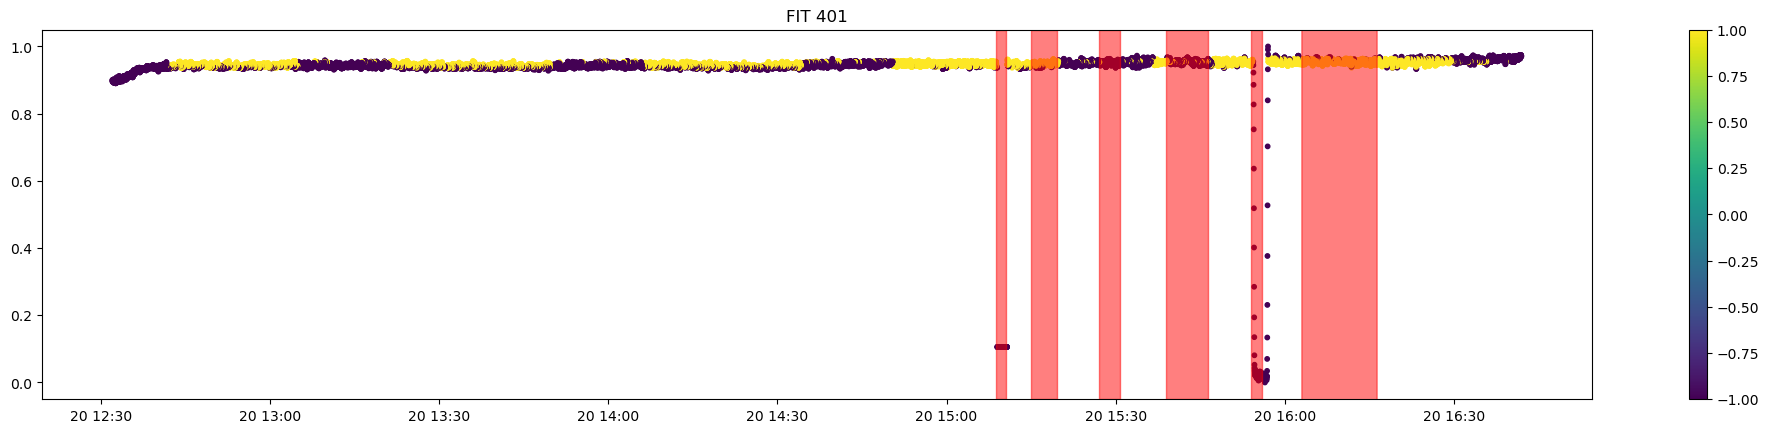

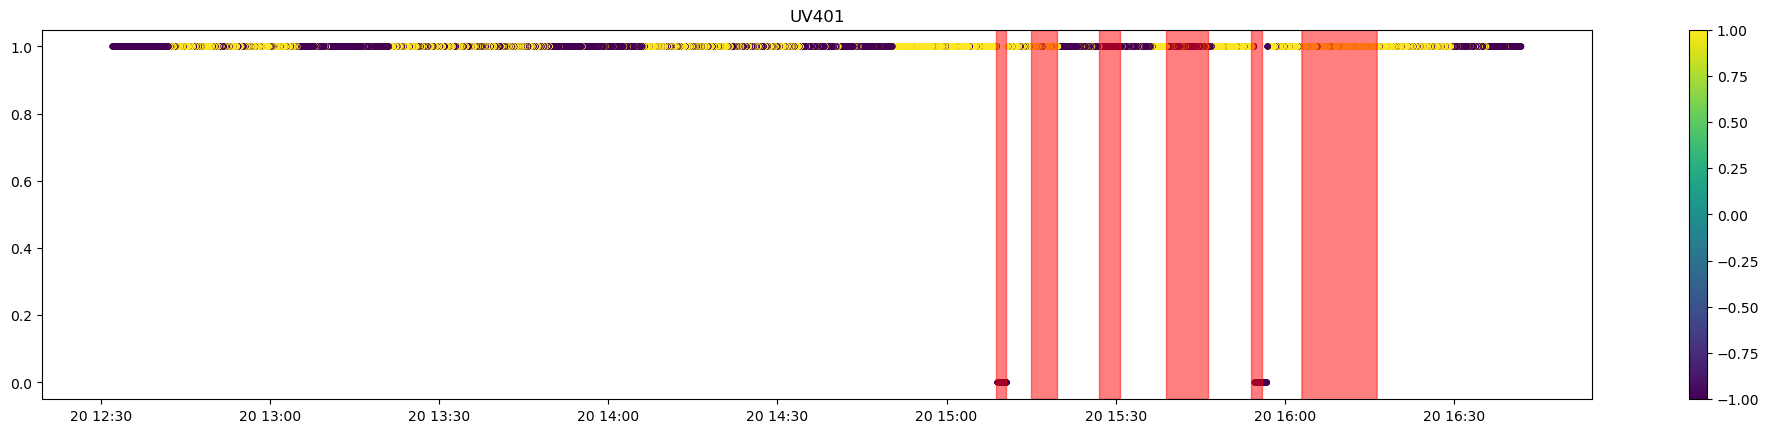

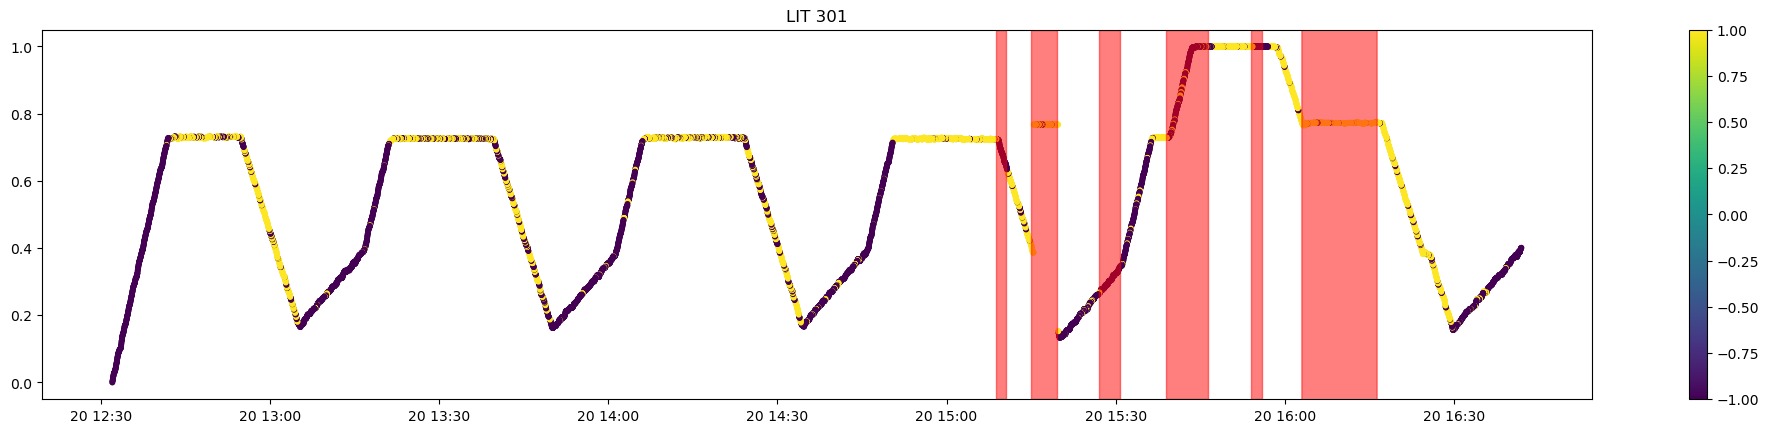

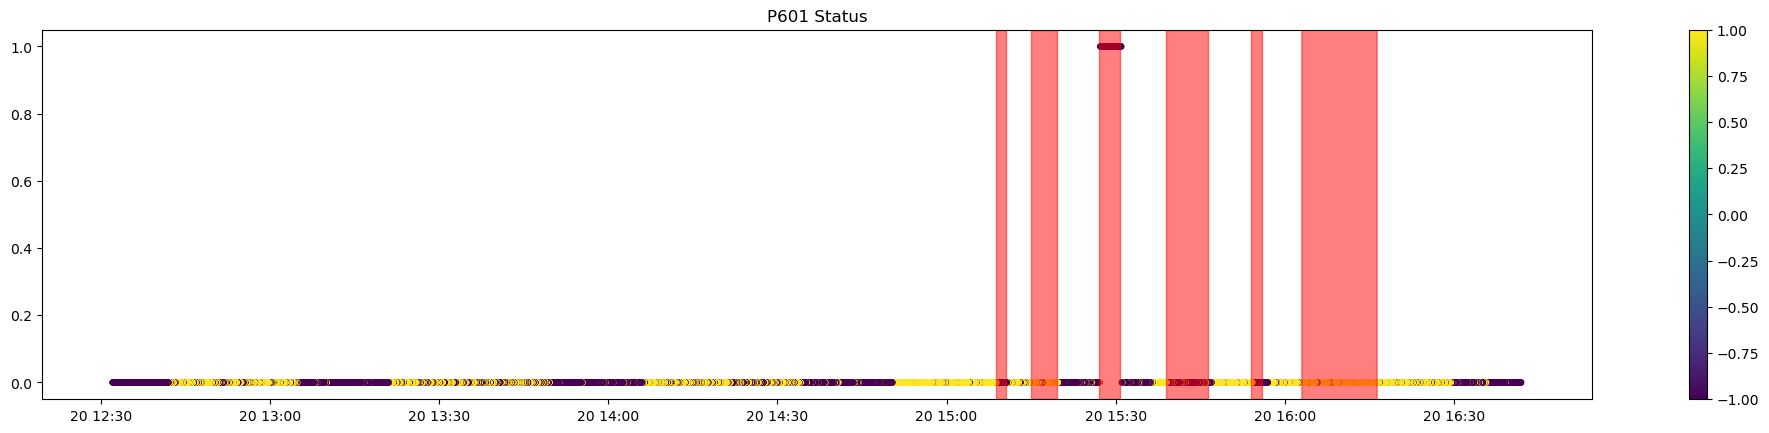

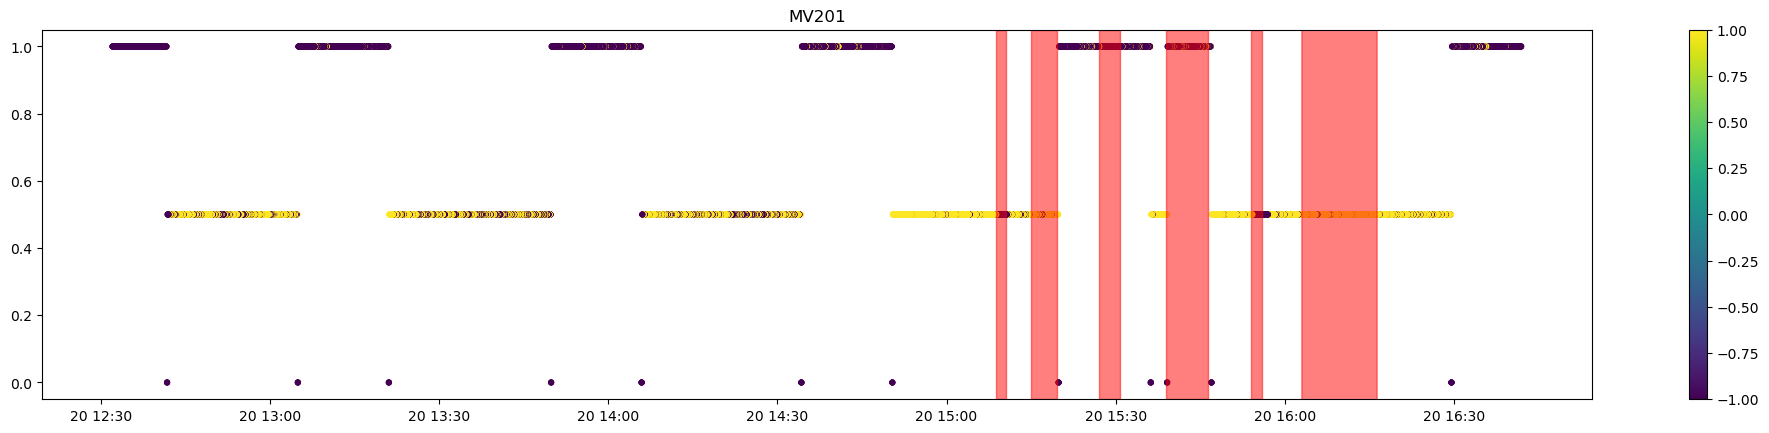

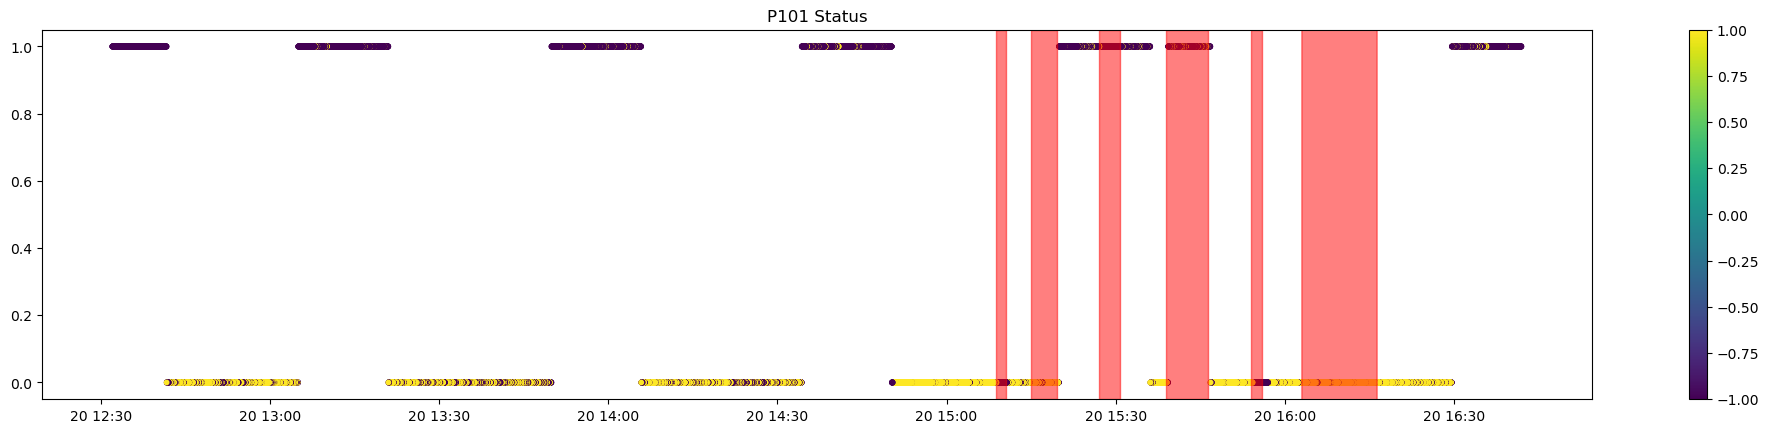

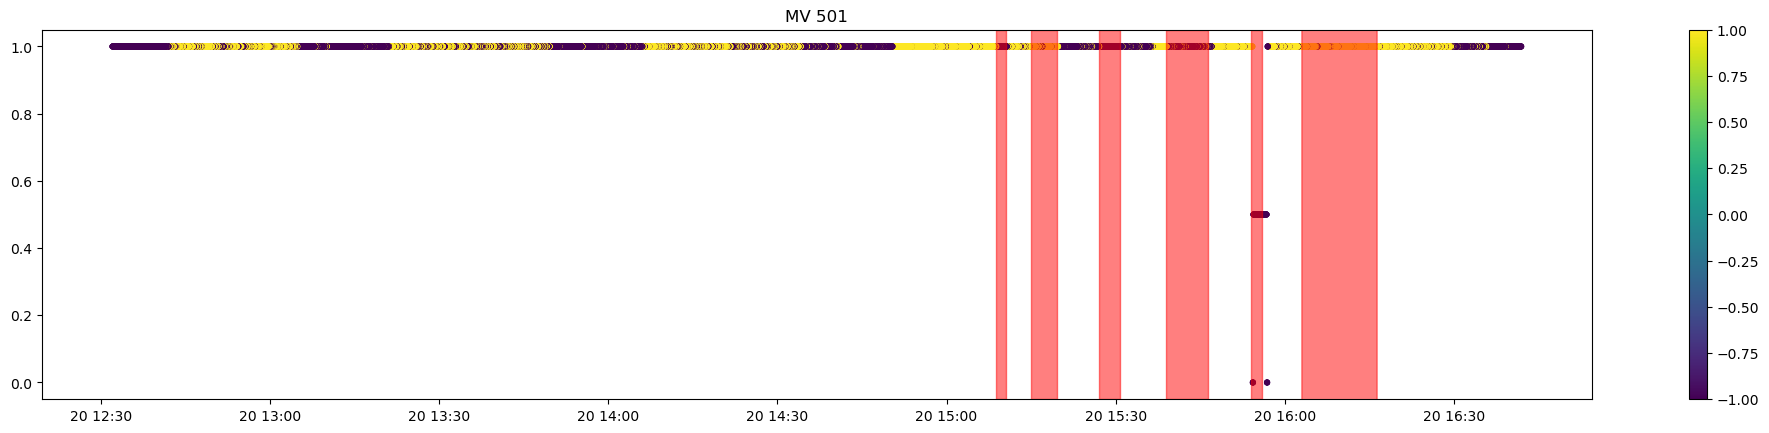

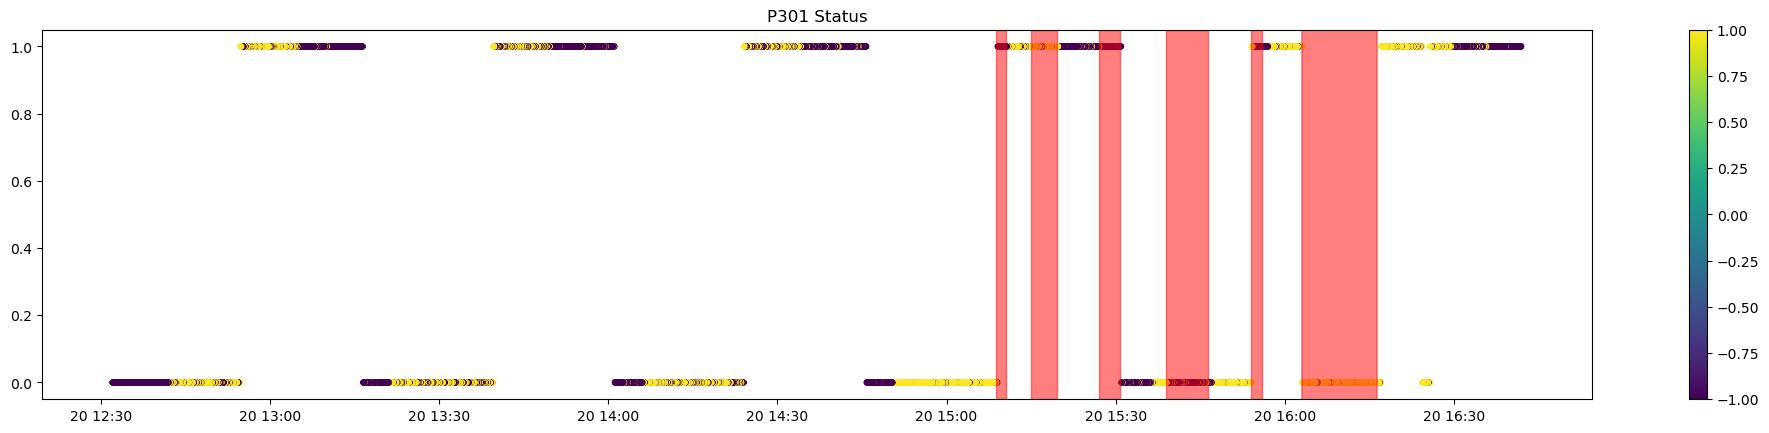

In [50]:
plot_df = read_data()
plot_df = preprocess_cat(plot_df)
plot_df = plot_df[features]
plot_df[features] = MinMaxScaler().fit_transform(plot_df[features])
plot_df.index = df.index
plot_df[best_model["name"]]=best_model['model'].predict(df)

for feature in features:
  plot_ts(plot_df.index, plot_df[feature], plot_df[best_model["name"]], title=feature)

In [57]:
num_of_anomalies = len(plot_df[plot_df[best_model["name"]] == -1])

In [58]:
print(f"total number of porint {len(plot_df)} and the number of anomaies {num_of_anomalies}")

total number of porint 14996 and the number of anomaies 7311
